# Policy gradient and actor critic algorithms

-- This is based on UCB Deep RL course --

In [1]:
import numpy as np
import tensorflow as tf
import gym
import scipy.signal
import os
import time
import inspect
from multiprocessing import Process

In [2]:

## Visualization purpose
import helper
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from matplotlib import pyplot as plt
from IPython.display import display

%matplotlib inline

In [3]:
env = gym.make('CartPole-v0')

[2018-01-08 15:42:51,102] Making new env: CartPole-v0


Number of step:  14



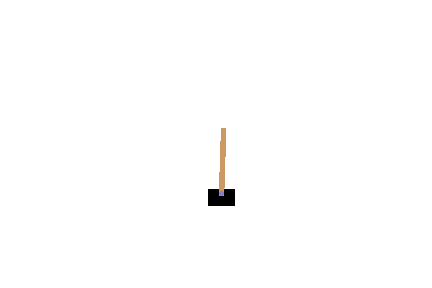
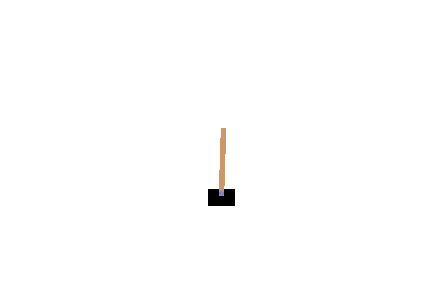
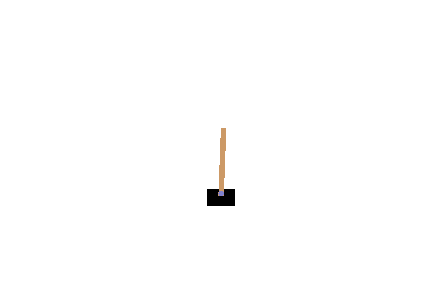
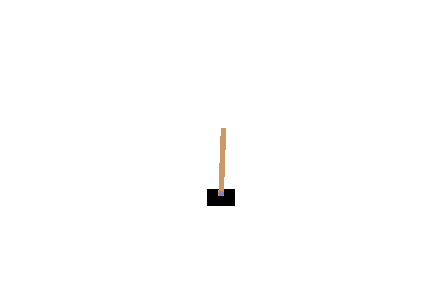
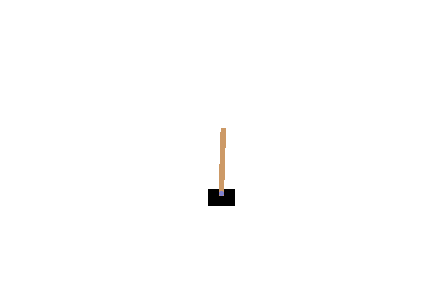
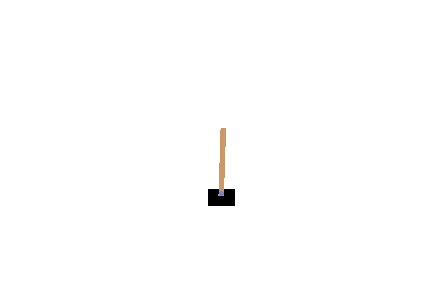
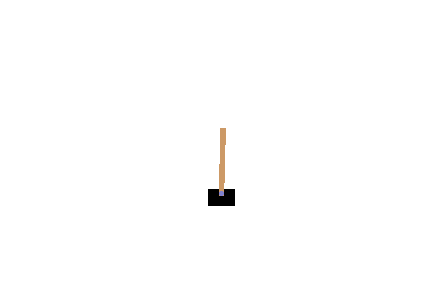
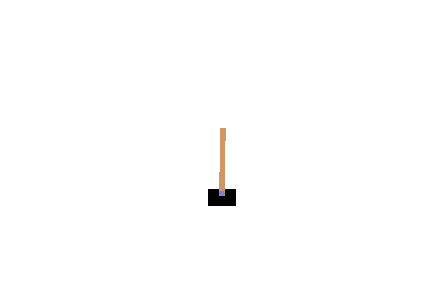
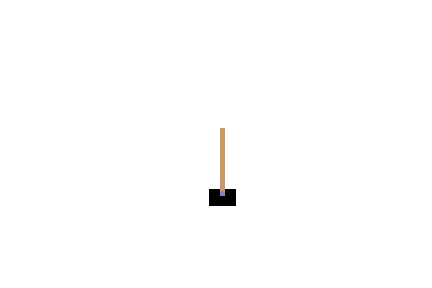
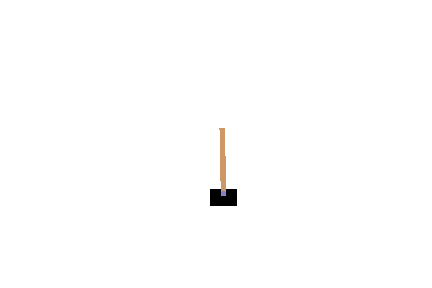
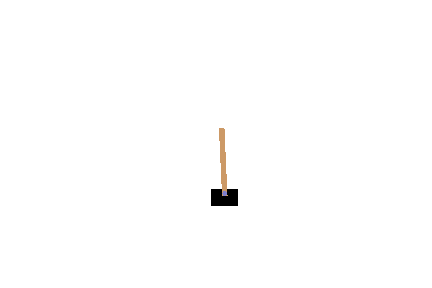
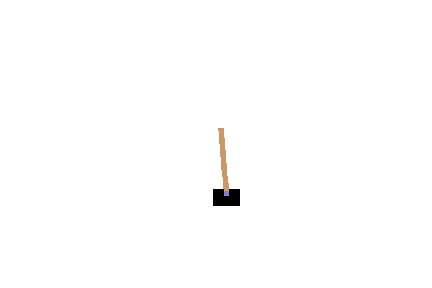
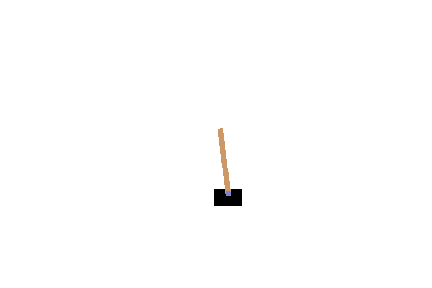
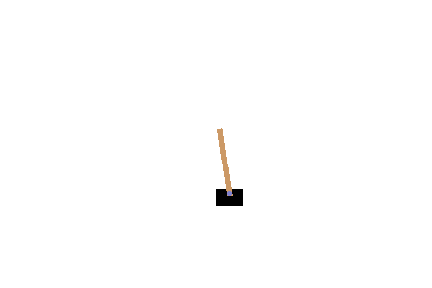
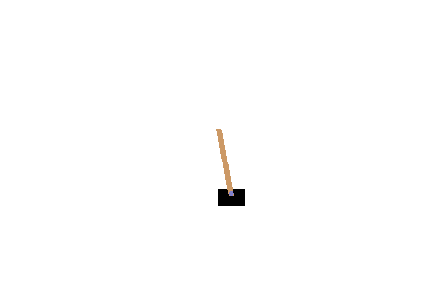

In [4]:
observation = env.reset()
cum_reward = 0
frames = []
for t in range(5000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    #print 'Observation: ', observation
    if done:
        print 'Number of step: ', t
        break
env.render(close=True)
helper.display_frames_as_gif(frames)  #<<< This one for Jupyter Notebook Display

In [5]:
state = env.observation_space
print 'Number of states:', state
print 'Number of available actions: ',env.action_space

Number of states: Box(4,)
Number of available actions:  Discrete(2)


In [6]:
def build_mlp(
        input_placeholder, 
        output_size,
        scope, 
        n_layers=2, 
        size=64, 
        activation=tf.tanh,
        output_activation=None
        ):

    with tf.variable_scope(scope):
        # YOUR_CODE_HERE
        layers = [0]*n_layers 
        for i in range(n_layers):
            if i == 0:
                layers[i] = tf.layers.dense(inputs = input_placeholder, units=size, activation= activation)
            else:
                layers[i] = tf.layers.dense(inputs = layers[i-1], units = size, activation=activation)
        output_layer = tf.layers.dense(inputs = layers[n_layers -1], units = output_size, activation= output_activation)
    return output_layer

In [7]:
#Test if our mlp run as we want it
x = tf.placeholder(tf.float32, [None, 1], name= "pixels_input")
y =build_mlp(x,1,"test_mlp0")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    out = sess.run([y], feed_dict = {x: [[3]]})
    print out

[array([[-0.24499497]], dtype=float32)]


In [8]:
def pathlength(path):
    return len(path["reward"])

REINFORCE algorithm

<img src = "REINFORCE.png"> 

In [9]:
ob_dim = env.observation_space.shape[0]
ac_dim = env.action_space.n
print 'Observation dimension: ',ob_dim
print 'Action dimension: ', ac_dim

Observation dimension:  4
Action dimension:  2


In [10]:
#Build a policy network
input_state = tf.placeholder(tf.float32, [None, ob_dim], name = 'State_input')
action_prob = build_mlp(input_state, ac_dim, "policy_network0") #policy network



# How to implement the above equation in Tensorflow (gradient)

- Consider just 1 episode
- In the feed_dict, we are going to input 3 things: state visited, action taken, reward received

In [11]:
#To use autodiff, we need to compute that loss function
sampled_action = tf.squeeze(tf.multinomial(action_prob, 1), axis=[1])

#
sy_ac_na = tf.placeholder(tf.int32, [None], name = 'Action_taken')
logprob_n = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=sy_ac_na, logits=action_prob) #action_prob requires input_state

#Loss function
learning_rate = 0.01
sy_ad_fn = tf.placeholder(shape=[None], name="adv", dtype=tf.float32) 
weighted_negative_likelihood = tf.multiply(logprob_n, sy_ad_fn) #note that in softmax_cross_entropy function, there is actually a minus sign
loss = tf.reduce_mean(weighted_negative_likelihood)
update_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


In [12]:
#Running 1 episode for illustration:

init = tf.global_variables_initializer() 
with tf.Session() as sess:
    sess.run(init)
    #Run 1 episode:
    obs, acs, rewards = [], [], []
    s = env.reset()
    done = False
    while not done:
        #Push the state into one list
        obs.append(s)
        ac_taken = sess.run(sampled_action, feed_dict={input_state: [s]}) #Take the sampled action
        acs.append(ac_taken)
        s, reward, done,info = env.step(ac_taken[0]) #Basically this is what we need
        rewards.append(reward)
    #We need to modify our reward function 
    for i in range(2, len(rewards)+1):
        rewards[-i] = rewards[-i] + rewards[-i +1]
    #We now got 3 elements to optimize our loss function:
    #Write whatever we need for debugging

In [13]:
#Start a real training
init = tf.global_variables_initializer() 
with tf.Session() as sess:
    sess.run(init)
    for i in range(100):
        print'Step #',i
        paths = []
        # ep_obs1, ep_acs1, ep_res1 = [], [], [] --Debugging 
        for iters in range(200): #Run 200 episodes to estimate the mean
            #Run 1 episode:
            obs, acs, rewards = [], [], []
            s = env.reset()
            done = False
            while not done:
                #Push the state into one list
                obs.append(s)
                ac_taken = sess.run(sampled_action, feed_dict={input_state: [s]}) #Take the sampled action
                acs.append(ac_taken[0])
                s, reward, done,info = env.step(ac_taken[0]) #Basically this is what we need
                rewards.append(reward)
            #We need to modify our reward function 
            for i in range(2, len(rewards)+1):
                rewards[-i] = rewards[-i] + rewards[-i +1]
            #We now got 3 elements to optimize our loss function:
            #ep_obs1.append(obs)  -- Debugging
            #ep_acs1.append(acs)  -- Debugging
            #ep_res1.append(rewards) -- Debugging
            path = {"observation" : np.array(obs), 
                    "reward" : np.array(rewards), 
                    "action" : np.array(acs)}
            paths.append(path)
        #Train it!
        ep_obs = np.concatenate([path["observation"] for path in paths])
        ep_acs = np.concatenate([path["action"] for path in paths])
        ep_res = np.concatenate([path["reward"] for path in paths])
        _, loss_value = sess.run([update_op, loss], feed_dict={input_state: ep_obs,
                                                               sy_ac_na: ep_acs,sy_ad_fn: ep_res})
        print 'Loss value:', loss_value
        
        s = env.reset()
        done = False
        total_rw = 0
        while not done:
            ac = sess.run(sampled_action, feed_dict={input_state: [s]})
            s, reward, done,info = env.step(ac[0])
            total_rw += reward
        print 'Total reward after 1 episode after fitting:', total_rw
        print "----------------------------------------"

Step # 0
Loss value: 7.79473
Total reward after 1 episode after fitting: 45.0
----------------------------------------
Step # 1
Loss value: 18.8641
Total reward after 1 episode after fitting: 55.0
----------------------------------------
Step # 2
Loss value: 23.1058
Total reward after 1 episode after fitting: 100.0
----------------------------------------
Step # 3
Loss value: 26.1672
Total reward after 1 episode after fitting: 132.0
----------------------------------------
Step # 4
Loss value: 35.4851
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 5
Loss value: 46.8635
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 6
Loss value: 47.0677
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 7
Loss value: 46.5116
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 8
Loss value: 46.3667
Total reward 

Loss value: 17.5461
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 69
Loss value: 17.3947
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 70
Loss value: 17.5273
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 71
Loss value: 17.6017
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 72
Loss value: 17.2723
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 73
Loss value: 17.8875
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 74
Loss value: 17.9242
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 75
Loss value: 17.4307
Total reward after 1 episode after fitting: 200.0
----------------------------------------
Step # 76
Loss value: 18.2973
Total reward

# Yahoo, just finished the REINFORCE algorithm for that (maximum reward achieved --200 in the case of cart pole, try other environments! (mountain car))
- Lower the number of episodes (from 200 to 10) to see how it affects the learning process
- Increase the learning rate for the same reason
- Now we are going to implement Actor-critic algorithm